<h3> Notebook Overview </h3>

- 1) Load source and target tensors
- 2) Load pre-trained tokenizers from json files
- 3) Load embedding matrices for source and target languages
- 4) Load pre-trained model
- 5) Define functions for translating random sentence 
- 6) Translate some random sentences

In [1]:
import json
import numpy as np
from keras.preprocessing.text import tokenizer_from_json
import tensorflow as tf
import seaborn as sns

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/Colab Notebooks/colab_upload

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/colab_upload


In [3]:
# Import from my own module
from model_components import Encoder, BahdanauAttention, Decoder

<h3> 1) Load source and target tensors (train + test) </h1>

In [5]:
# ## For colab

# file_path = '/content/gdrive/MyDrive/attention_data/tensors/'

# source_train_tensor = np.loadtxt(file_path + 'source_train_tensor.csv', delimiter = ',', dtype = 'int32')
# source_test_tensor = np.loadtxt(file_path + 'source_test_tensor.csv', delimiter = ',', dtype = 'int32')
# target_train_tensor = np.loadtxt(file_path + 'target_train_tensor.csv', delimiter = ',', dtype = 'int32')
# target_test_tensor = np.loadtxt(file_path + 'target_test_tensor.csv', delimiter = ',', dtype = 'int32')

In [6]:
# load source & train arrays from csv file:
source_train_tensor = np.loadtxt('tensors/source_train_tensor.csv', delimiter = ',', dtype = 'int32')
source_test_tensor = np.loadtxt('tensors/source_test_tensor.csv', delimiter = ',', dtype = 'int32')
target_train_tensor = np.loadtxt('tensors/target_train_tensor.csv', delimiter = ',', dtype = 'int32')
target_test_tensor = np.loadtxt('tensors/target_test_tensor.csv', delimiter = ',', dtype = 'int32')

In [7]:
max_source_length= max(len(t) for t in np.concatenate((source_train_tensor, source_test_tensor), axis=0))
max_target_length= max(len(t) for t in np.concatenate((target_train_tensor, target_test_tensor), axis=0))

print(max_source_length, max_target_length)

77 103


<h3> 2) Load pre-trained tokenizers from json files </h3>

In [8]:
with open ('tokenizers/source_sentence_tokenizer.json') as f:
    data = json.load(f)
    source_sentence_tokenizer = tokenizer_from_json(data)

with open ('tokenizers/target_sentence_tokenizer.json') as f:
    data = json.load(f)
    target_sentence_tokenizer = tokenizer_from_json(data)


# word-to-index and index-to-word mappings from tokenizers
source_word_index = source_sentence_tokenizer.word_index
target_word_index = target_sentence_tokenizer.word_index

source_index_word = source_sentence_tokenizer.index_word
target_index_word = target_sentence_tokenizer.index_word

In [9]:
# size of vocab, and number of tokens, for source and target languages

vocab_len_source = len(source_word_index.keys())
vocab_len_target = len(target_word_index.keys())

num_tokens_source = vocab_len_source + 1
num_tokens_target = vocab_len_target + 1

<h3> 3) Load embedding matrices for source and target languages </h3>

In [10]:
# ## For colab

# file_path = '/content/gdrive/MyDrive/attention_data/embeddings/'

# embedding_matrix_source = np.loadtxt(file_path + 'embedding_matrix_source.csv', delimiter = ',', dtype = 'int32')
# embedding_matrix_target = np.loadtxt(file_path + 'embedding_matrix_target.csv', delimiter = ',', dtype = 'int32')

In [11]:
# load embedding matrices
embedding_matrix_source = np.loadtxt('embeddings/embedding_matrix_source.csv', delimiter = ',', dtype = 'int32')
embedding_matrix_target = np.loadtxt('embeddings/embedding_matrix_target.csv', delimiter = ',', dtype = 'int32')

In [12]:
# Retrieve embedding dimensions for source and target languages
embedding_dim_source = embedding_matrix_source.shape[1]
embedding_dim_target = embedding_matrix_target.shape[1]

print(embedding_dim_source, embedding_dim_target)

96 300


<h3> 4) Load pre-trained model </h3>

- Define all arguments for the model components

In [13]:
BATCH_SIZE = 32
BUFFER_SIZE = len(source_train_tensor)
steps_per_epoch= BUFFER_SIZE//BATCH_SIZE

#embedding_dim = 256
num_tokens_source = num_tokens_source
num_tokens_target = num_tokens_target

embedding_dim_source = embedding_dim_source
embedding_dim_target = embedding_dim_target

units = 256
attention_layer_units = 100

In [14]:
# Instantiate model components
encoder = Encoder(num_tokens_source, embedding_dim_source, units, BATCH_SIZE, embedding_matrix_source)
decoder = Decoder(num_tokens_target, embedding_dim_target, 2*units, BATCH_SIZE, embedding_matrix_target, attention_layer_units)

# Load pre-trained weights
file_path = 'saved_models/model'
encoder.load_weights(file_path + '/encoder')
decoder.load_weights(file_path + '/decoder')


<h3> 5) Define functions for translating </h3>

- Sentences (or rather, integer sequences) will be selected randomly from either the training or test set 

In [15]:
def evaluate(inputs, encoder, decoder, max_source_length, max_target_length):
    """
    Translates input sequence into sentence in target language and computes 2D attention_plot
    The attention_plot tells you: for each word in output, how much attention was paid to each word in input
    
    Arguments: 
    inputs -- (1, Tx) -- input sequence of integers
    encoder -- instance of Encoder subclass 
    decoder -- instance of Decoder subclass
    max_source_length -- int
    max_target_length -- int

    Returns:
    result -- predicted sentence in words
    input_sentence -- input sentence in words
    attention_plot -- (max_target_length, max_source_length)
    """
    
    # Initialise attention_plot with 0s
    attention_plot = np.zeros((max_target_length, max_source_length))
    
    # Translate sequence of integers into words
    input_sentence = ''
    for i in inputs[0]:
        if i == 0:
            break
        input_sentence = input_sentence + source_sentence_tokenizer.index_word[i] + ' '
    
    # Convert input sequence of integers into Tensor
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    # Pass inputs through Encoder
    enc_sequential, enc_final_h, enc_final_c = encoder(inputs)

    # Initialise Decoder hidden state and cell state with final states of Encoder
    dec_h = enc_final_h
    dec_c = enc_final_c
    
    # Initialise Decoder input with "start_" 
    # Expand dimensions for broadcastability
    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)             # dec_input = (1, 1)

    # Decoder:
    # Input: y, dec_h, dec_c, enc_sequential
    # Return: y, dec_h, dec_c, attention_weights

    # Decode one time-step at a time
    for t in range(max_target_length):
        predictions, dec_h, dec_c, attention_weights = decoder(dec_input, dec_h, dec_c, enc_sequential)    # predictions = (1, vocab_size)
                                                                                                           # dec_h = (1, 2*units)
                                                                                                           # dec_c = (1, 2*units)
        # flatten attention_weights
        attention_weights = tf.reshape(attention_weights, (-1, ))
        # update t'th row of attention_plot matrix
        attention_plot[t] = attention_weights.numpy()
        
        # Retrieve index with maximum probability
        predicted_id = tf.argmax(predictions[0]).numpy()
        # Add word corresponding to the index to "result"
        result += target_sentence_tokenizer.index_word[predicted_id] + ' '

        # stop decoding if '_end' is predicted
        if target_sentence_tokenizer.index_word[predicted_id] == '_end':
            return result, input_sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)                                         # dec_input = (1,1)  

    return result, input_sentence, attention_plot


In [16]:
def predict_random_sentence(source_tensor = source_train_tensor, target_tensor = target_train_tensor):
    """
    Select random input sequence from source_tensor and translate it into target language. 
    Also plot heatmap of attention scores
    """
    
    # select random integer "k"
    k = np.random.randint(len(source_tensor))

    # Retrieve random input sequence and expand dimensions
    random_input = source_tensor[k]
    random_input = np.expand_dims(random_input,0)           # random_input = (1, Tx)

    # Retrieve corresponding ground-truth output sequence
    random_output = target_tensor[k]
    
    # Call "evaluate" function to get translation and attention_plot
    result, sentence, attention_plot = evaluate(random_input, encoder, decoder, max_source_length, max_target_length)
    
    # Round attention scores to 3 decimal places
    attention_plot = np.around(attention_plot, decimals = 3)

    # Convert ground-truth output sequence into string
    true_translation = ''
    for i in random_output:
        if i == 0:
            break
        true_translation = true_translation + target_sentence_tokenizer.index_word[i] + ' '

    print(f'Input: {sentence}')
    print(f'Predicted translation: {result}')
    print(f'Actual translation: {true_translation}')

    # Split "result" and "sentence" into words; 
    # Index up to -1 to remove empty string at the end
    sentence = sentence.split(' ')[:-1]
    result = result.split(' ')[:-1]

    # Select non-zero section of attention_plot
    # Split "result" and "sentence" into words; subtract 1 to remove empty string
    attention_plot = attention_plot[:len(result), :len(sentence)]
    
    # Plot heatmap of attention scores
    sns.heatmap(attention_plot, cmap = 'hot', annot = True, xticklabels = sentence, yticklabels = result)

<h3> 6) Translate some random sentences </h3>

- Sentences from training set

Input: start_ ich bleibe heute zu hause _end 
Predicted translation: im staying at home today _end 
Actual translation: start_ ill stay at home today _end 


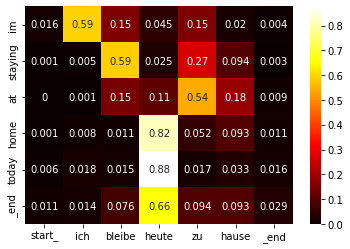

In [25]:
predict_random_sentence(source_train_tensor, target_train_tensor)

Input: start_ ich habe an jedem zweiten tage unterricht _end 
Predicted translation: i have a second school every minute _end 
Actual translation: start_ i have a class every other day _end 


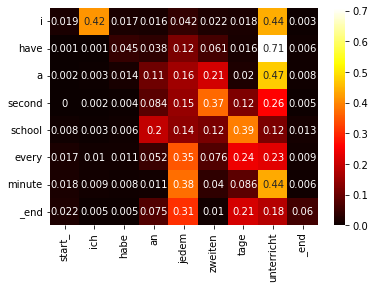

In [26]:
predict_random_sentence(source_train_tensor, target_train_tensor)

Input: start_ du wirst es lieben _end 
Predicted translation: youll love it _end 
Actual translation: start_ youll love it _end 


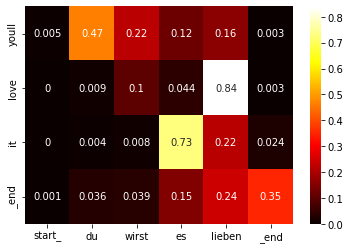

In [27]:
predict_random_sentence(source_train_tensor, target_train_tensor)

Input: start_ sprich mit jemandem _end 
Predicted translation: talk to somebody _end 
Actual translation: start_ talk to somebody _end 


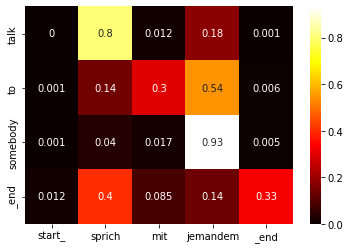

In [28]:
predict_random_sentence(source_train_tensor, target_train_tensor)

Input: start_ du haeltst dich wohl fuer besser als mich was _end 
Predicted translation: you think youre better for me _end 
Actual translation: start_ you think youre better than me dont you _end 


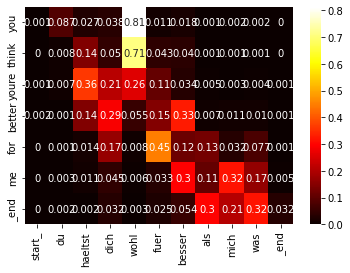

In [29]:
predict_random_sentence(source_train_tensor, target_train_tensor)

Input: start_ ihr koennt heute hier schlafen _end 
Predicted translation: you can sleep here tonight _end 
Actual translation: start_ you can sleep here tonight _end 


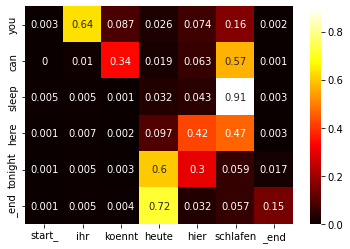

In [30]:
predict_random_sentence(source_train_tensor, target_train_tensor)

Input: start_ ihre idee ist meiner sehr aehnlich _end 
Predicted translation: her idea is similar to mine _end 
Actual translation: start_ her idea is very similar to mine _end 


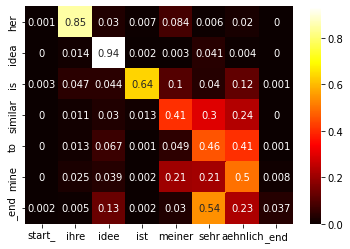

In [31]:
predict_random_sentence(source_train_tensor, target_train_tensor)

- Sentences from test set

Input: start_ dies ist das dorf in dem ich meine kindheit verbracht habe _end 
Predicted translation: this is the village i spent my friends in my childhood _end 
Actual translation: start_ this is the village where i spent my childhood _end 


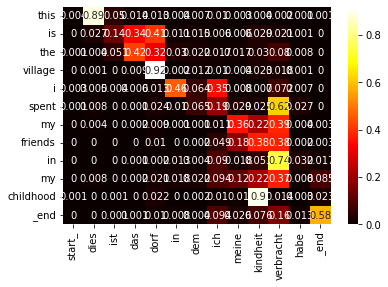

In [17]:
predict_random_sentence(source_test_tensor, target_test_tensor)

Input: start_ irgend etwas sagt mir ich haette nein sagen sollen _end 
Predicted translation: i like a feeling i told me _end 
Actual translation: start_ something tells me i shouldve said no _end 


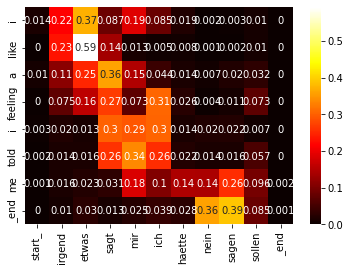

In [18]:
predict_random_sentence(source_test_tensor, target_test_tensor)

Input: start_ es war dunkel als ich das hotel erreichte _end 
Predicted translation: it was dark when i reached the hotel _end 
Actual translation: start_ it was dark when i reached the hotel _end 


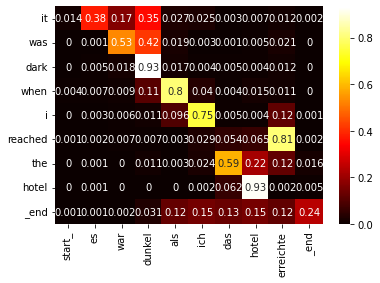

In [19]:
predict_random_sentence(source_test_tensor, target_test_tensor)

Input: start_ ich haette heute morgen frueher aufstehen sollen _end 
Predicted translation: i shouldve gotten up this morning for this morning _end 
Actual translation: start_ i shouldve gotten up earlier this morning _end 


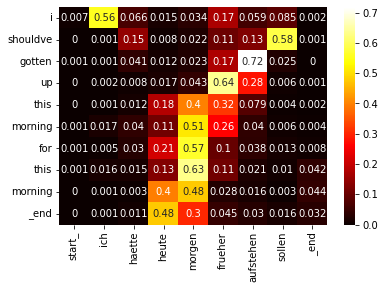

In [20]:
predict_random_sentence(source_test_tensor, target_test_tensor)

Input: start_ schoenen abend _end 
Predicted translation: have a look good night _end 
Actual translation: start_ goodnight _end 


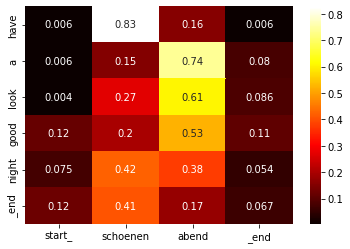

In [21]:
predict_random_sentence(source_test_tensor, target_test_tensor)

Input: start_ hast du mein gruenes hemd gesehen _end 
Predicted translation: did you see my green shirt _end 
Actual translation: start_ have you seen my green shirt _end 


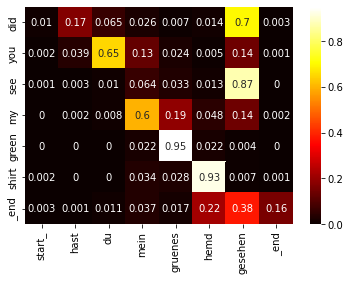

In [22]:
predict_random_sentence(source_test_tensor, target_test_tensor)

Input: start_ was weisst du darueber _end 
Predicted translation: what do you know about that _end 
Actual translation: start_ what do you know about that _end 


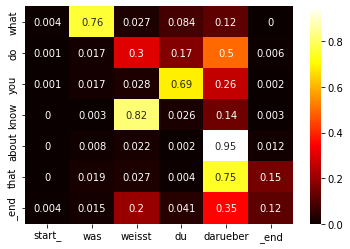

In [23]:
predict_random_sentence(source_test_tensor, target_test_tensor)

Input: start_ sobald sie zurueck sind rufe ich sie an _end 
Predicted translation: as soon as youre back ill phone you _end 
Actual translation: start_ as soon as they return i will telephone you _end 


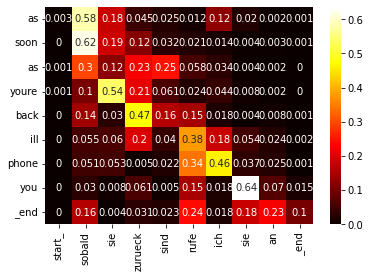

In [24]:
predict_random_sentence(source_test_tensor, target_test_tensor)